<h3>Non intrusive load monitoring</h3>
<h4>Project Summary</h4>

Objective - to build a machine learning based algorithm thatautomatically and accurately identifies what appliances are connected to the power supply.This is a multilabel multiclass classification problem.

<h5>Steps:</h5>

-Read the train and test datasets.

-Perform Kmeans clustering on training datasets and assign label to each of the dataset based on the clusters.

-Merge 3 datasets into one which gives combined load info and device states,so that its similar to test data format.

-Drop unnecessary columns - Date:-Date column can be dropped as the datetime values are mutually exclusive in all 3 datasets.

-Normalise dataset (which is not necessary as the model is Randomforest).

-Initialise the model using LabelPowerSet(skmultilearn library), a problem transformation technique for multilabel problem.http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset

-Perform stratified crossvalidation on the dataset using MultiLabelStratifiedKfold method(iterstrat.ml_stratifiers library).

-Apply trained model on preprocessed test dataset.

-Make Predictions and save results.

<h5>Drawbacks:</h5>

-Model was able to predict multiple labels,however couldn't predict multiple classes.Model was able to predict binary classes for each label i.e For PC1 and PC2 model predicted 'on' and 'off' state,but 'idle state'.

-Training dataset was labelled based on assumptions derived from cluster assignments which may not be true.


<h5>Future improvements:</h5>

-Try different models and methods to solve a multilabel multiclass classification problem.

-Explore non intrusive load monitoring techniques.

<h6>Reference:</h6>

https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset

https://github.com/trent-b/iterative-stratification


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [3]:
#Functions
def plot_labelled_scatter(X, y, class_labels):
    '''
    plot clusters predicted by Kmeans
    '''
    num_labels = len(class_labels)

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)



    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()
    
def Cross_validate(df_new,target,RF):
    '''
    -Randomforest model was trained on 5 stratified folds.
    -Accuracy is used for evaluating the models trained on each fold.
    -The predictions contain values for 3 labels.
    -So we extracted the values for each predicted labels and calculate the accuracy labelwise.
    -Took the average of the 3 accuracy scores as the final score
    '''
    
    mskf = MultilabelStratifiedKFold(n_splits=5,random_state=0)
    #Crossvalidating using 5 stratified KFolds
    rf_accuracy_pc1=[]
    rf_accuracy_pc2=[]
    rf_accuracy_sensor=[]

    for train_index, test_index in mskf.split(df_new, target):
        train_df, test_df = df_new[train_index], df_new[test_index]
        train_target, test_target = target[train_index], target[test_index]
        RF.fit(train_df, train_target)
        
        #predicting test data outputs
        predictions = RF.predict(test_df)
        
        #Get predictions for label PC1 screen state
        extractedData1 = predictions[:,[0]]
        z = scipy.sparse.csr_matrix(test_target)
        extractedData2 = z[:,[0]]


       # Flatten both the array and print the accuracy score for label PC1 screen state
        actual1 = extractedData2.toarray().flatten()
        predicted1 = extractedData1.toarray().flatten()
        rf_accuracy_pc1.append(accuracy_score(actual1, predicted1))  

        #Get predictions for label PC2 screen state
        extractedData1_1 = predictions[:,[1]]
        z1 = scipy.sparse.csr_matrix(test_target)
        extractedData2_1 = z1[:,[1]]

        # Flatten both the array and print the accuracy score for label PC2 screen state
        actual2 = extractedData2_1.toarray().flatten()
        predicted2 = extractedData1_1.toarray().flatten()
        rf_accuracy_pc2.append(accuracy_score(actual2, predicted2)) 

        #Get predictions for label Temperature sensor state
        extractedData1_2 = predictions[:,[2]]
        z2 = scipy.sparse.csr_matrix(test_target)
        extractedData2_2 = z2[:,[2]]

        # Flatten both the array and print the accuracy score for label Temperature sensor state
        actual3 = extractedData2_2.toarray().flatten()
        predicted3 = extractedData1_2.toarray().flatten()
        rf_accuracy_sensor.append(accuracy_score(actual3, predicted3)) 


    print("Accuracy score for PC1 screen state:",np.round(np.mean(rf_accuracy_pc1),decimals=2))
    print("Accuracy score for PC2 screen state:",np.round(np.mean(rf_accuracy_pc2),decimals=2))
    print("Accuracy score for for Temperature sensor state:",np.round(np.mean(rf_accuracy_sensor),decimals=2))
    print("Average Accuracy score:", np.round(np.mean([np.mean(rf_accuracy_pc1),np.mean(rf_accuracy_pc2),np.mean(rf_accuracy_sensor)]),decimals=2))
    return RF   
    

In [4]:
#Read all files

In [5]:
df1 = pd.read_csv('test_data1536128609.98_screen1.csv', 
                  names=["date", "Maxpower", "Effpower"])
df2 = pd.read_csv('test_data1536128871.84_screen2.csv', 
                  names=["date", "Maxpower", "Effpower"])
df3 = pd.read_csv('test_data1536129261.77_device253.csv', 
                  names=["date", "Maxpower", "Effpower"])
df_test= pd.read_csv('test_data1536129670.55_main.csv', 
                  names=["date", "Maxpower", "Effpower"])

In [6]:
#Convert timestamp to readable datetime format
df1['date'] = pd.to_datetime(df1['date'],unit='s')
df2['date'] = pd.to_datetime(df2['date'],unit='s')
df3['date'] = pd.to_datetime(df3['date'],unit='s')

df_test['date'] = pd.to_datetime(df_test['date'],unit='s')


-This is a multilabel multi class classification problem.

-There are no labels provided in the training dataset.

-It can be treated as a unsupervised machine learning problem.However the 3 training datasets indicates the states of individual devices ,but the Test dataset containes combined loads of 3 devices.

-As the training datasets gives individual load info and no labels,I decided to convert this into a supervised problem.

-I have used Kmeans clustering to find the labels for the training dataset based on the clusters predicted by the Kmeans.Assigned labels to each dataset and merged the 3 datasets of individual loads into one.

-The Final merged training dataset contains combined loads of 3 devices and their states.Thus the training and test datasets have similar data.

<h4>Kmeans on PC1 screen state dataset</h4>

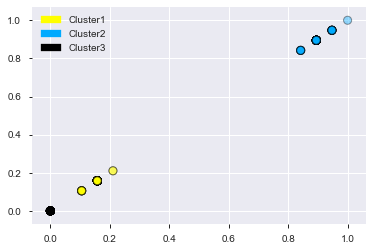

In [7]:

kmeans_df1 = KMeans(n_clusters = 3)
#Drop timestamp(date) column 
df1.drop(df1.columns[0],axis=1,inplace=True)
df1_orgn=df1.copy()
df1_norm=MinMaxScaler().fit(df1_orgn).transform(df1_orgn)
kmeans_df1.fit(df1_norm)

plot_labelled_scatter(df1_norm,kmeans_df1.labels_,['Cluster1','Cluster2','Cluster3'])

#Create new column for PC1 screen state labels and Assign cluster ids
df1['PC screen1 state'] = kmeans_df1.labels_
# print(kmeans_df1.labels_)

#cluster 1 - idle, cluster 2- on, cluster 3- off
df1.loc[df1['PC screen1 state'] == 0, 'PC screen1 state'] = 'idle'
df1.loc[df1['PC screen1 state'] == 1, 'PC screen1 state'] = 'on'
df1.loc[df1['PC screen1 state'] == 2, 'PC screen1 state'] = 'off'

#Assign correspoding values for the labels :
# idle -2
# on -1
# off -0
df1.loc[df1['PC screen1 state'] == 'off']
df1.loc[df1['PC screen1 state'] == 'idle', 'PC screen1 state'] = 2
df1.loc[df1['PC screen1 state'] == 'on', 'PC screen1 state'] = 1
df1.loc[df1['PC screen1 state'] == 'off', 'PC screen1 state'] = 0

<h4>Kmeans on PC2 screen state dataset</h4>

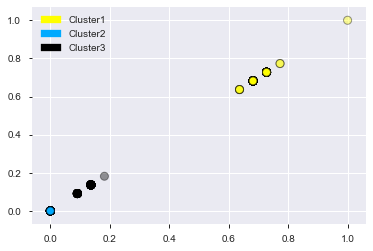

In [8]:
kmeans_df2 = KMeans(n_clusters = 3)
df2.drop(df2.columns[0],axis=1,inplace=True)
df2_orgn=df2.copy()
df2_norm=MinMaxScaler().fit(df2_orgn).transform(df2_orgn)
kmeans_df2.fit(df2_norm)

plot_labelled_scatter(df2_norm,kmeans_df2.labels_,['Cluster1','Cluster2','Cluster3'])

#Create new column for PC2 screen state labels and Assign cluster ids
df2['PC screen2 state'] = kmeans_df2.labels_

#cluster 1 - idle, cluster 2- on, cluster 3- off
df2.loc[df2['PC screen2 state'] == 1, 'PC screen2 state'] = 'on'
df2.loc[df2['PC screen2 state'] == 2, 'PC screen2 state'] = 'off'
df2.loc[df2['PC screen2 state'] == 0,'PC screen2 state'] = 'idle'

#Reassign meaningful values for the labels :
# idle -2
# on -1
# off -0
df2.loc[df2['PC screen2 state'] == 'on', 'PC screen2 state'] = 1
df2.loc[df2['PC screen2 state'] == 'idle', 'PC screen2 state'] = 2
df2.loc[df2['PC screen2 state'] == 'off','PC screen2 state'] = 0

<h4>Kmeans on Temperature sensor state dataset</h4>

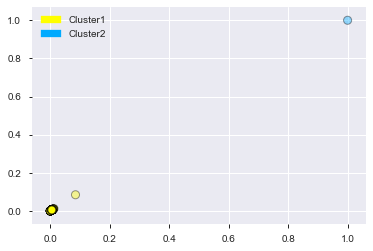

In [9]:
kmeans_df3 = KMeans(n_clusters = 2)
df3.drop(df3.columns[0],axis=1,inplace=True)

df3_orgn=df3.copy()
df3_norm=MinMaxScaler().fit(df3_orgn).transform(df3_orgn)
kmeans_df3.fit(df3_norm)
# y_kmeans = kmeans_df1.fit_predict(df1)
plot_labelled_scatter(df3_norm,kmeans_df3.labels_,['Cluster1','Cluster2'])

#Create new column for Temperature sensor state labels and Assign cluster ids
df3['Temperature sensor state'] = kmeans_df3.labels_

df3.loc[df3['Effpower'] == 0,'Temperature sensor state'] = 'off'
df3.loc[df3['Effpower'] > 0,'Temperature sensor state'] = 'on'

#Assign correspoding values for the labels :
# on -1
# off -0
df3.loc[df3['Effpower'] == 0,'Temperature sensor state'] = 0
df3.loc[df3['Effpower'] > 0,'Temperature sensor state'] = 1

<h4>Merge datasets</h4>

-Since we are done with clustering and labelling each device dataset,we will merge them into one dataset.

-Final merged dataset will have combined load values of 3 devices and their corresponding states.

In [10]:
#Sum the Effective power and Maximum power values of 3 datasets.
df_merge = df1.iloc[:,0:2] + df2.iloc[:,0:2] + df3.iloc[:,0:2]
#Add states of each devices.
df_merge['PC screen1 state']=df1['PC screen1 state']
df_merge['PC screen2 state']=df2['PC screen2 state']
df_merge['Temperature sensor state']=df3['Temperature sensor state']

#As the datasets have unequal number of rows,null values are replaced with 0
df_merge = df_merge.fillna(0)

-Our dataset is ready for training and we can start training the model using this dataset.

-Since this is a multilabel classification problem,I am going to use a python library called 'scikit-multilearn'.

-We will use a method called LabelPowerset which is a problem transformation technique.

-This technique transforms the problem into a multi-class problem with one multi-class classifier trained on all unique label combinations found in the training data.

-For cross validation,we will use a method called 'MultilabelStratifiedKFold' from library 'iterstrat.ml_stratifiers'.

<h4>Training RandomForest</h4>

In [11]:
# Steps taken for training:

#     -Separate features and labels
    
#     -Create Randomforest model instance using LabelPowerset method
    
#     -Cross validate the model using MultilabelStratifiedKFold method
    

from skmultilearn.problem_transform import BinaryRelevance,LabelPowerset
from skmultilearn.utils import measure_per_label
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report,accuracy_score
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.sparse as sp

RF = LabelPowerset(RandomForestClassifier(n_estimators=20,random_state=42))

print('Preparing data..... ')
target=df_merge[['PC screen1 state','PC screen2 state','Temperature sensor state']].values
df_merge.drop(['PC screen1 state','PC screen2 state','Temperature sensor state'],axis=1,inplace=True)

print(' 1.Drop Date')
print(' 2.Normalise dataset ')
#Normalise data
std=StandardScaler()
df_merge=std.fit_transform(df_merge)
# df_merge=df_merge.reset_index().values

#crossvalidate the random forest model on train dataset
print('Training the model.....')
print('Cross validating model..... ')
print('Accuracy Scores')
print('-'*40)
trained_RF=Cross_validate(df_merge,target,RF)


Preparing data..... 
 1.Drop Date
 2.Normalise dataset 
Training the model.....
Cross validating model..... 
Accuracy Scores
----------------------------------------
Accuracy score for PC1 screen state: 0.66
Accuracy score for PC2 screen state: 0.44
Accuracy score for for Temperature sensor state: 0.83
Average Accuracy score: 0.64


<h4>Testing</h4>

In [12]:
#test-Make predictions
#drop date column before testing
df_test.drop(df_test.columns[0],axis=1,inplace=True)

#Normalise data
std=StandardScaler()
df_test=std.fit_transform(df_test)
# df_test=df_test.reset_index().values

#Use trained randomforest model to make predictions
predictions = trained_RF.predict(df_test)

df_output=pd.DataFrame()
#Extract predicted  state for device -PC1
predicted1 = predictions[:,[0]]
df_output['PC screen1 state'] = predicted1.toarray().flatten()

#Replace labels with device state
df_output.loc[df_output['PC screen1 state'] == 0, 'PC screen1 state'] = 'off'
df_output.loc[df_output['PC screen1 state'] == 1, 'PC screen1 state'] = 'on'
df_output.loc[df_output['PC screen1 state'] == 2, 'PC screen1 state'] = 'idle'

#Extract predicted  state  for device -PC2
predicted2 = predictions[:,[1]]
df_output['PC screen2 state'] = predicted2.toarray().flatten()
#Replace labels with device state
df_output.loc[df_output['PC screen2 state'] == 0, 'PC screen2 state'] = 'off'
df_output.loc[df_output['PC screen2 state'] == 1, 'PC screen2 state'] = 'on'
df_output.loc[df_output['PC screen2 state'] == 2, 'PC screen2 state'] = 'idle'


#Extract predicted  state  for device -Sensor
predicted3 = predictions[:,[2]]
df_output['Temperature sensor state'] = predicted3.toarray().flatten()
#Replace labels with device state
df_output.loc[df_output['Temperature sensor state'] == 0, 'Temperature sensor state'] = 'off'
df_output.loc[df_output['Temperature sensor state'] == 1, 'Temperature sensor state'] = 'on'

<h4>Save Results</h4>

In [13]:
#Create test file
df_test= pd.read_csv('test_data1536129670.55_main.csv', 
                  names=["timestamp", "Maximum current", "Effective current"])
df_output = pd.concat([df_test,df_output], axis=1)
df_output.to_csv('Test_Output.csv', index=False)